In [2]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


In [17]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

bdes.zip
fearful
savee
calm
happy
surprised
angry
sad
keywords


In [4]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [5]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [6]:
# This function prints metrics about a model
def print_metrics(X, Y, label_name_list):
    Y_pred = vm.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))


In [7]:
# Create class
class EmotionClassifierLstm(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        # This first layer add noises to the input data and serve as a data augmentation technique
        # Used to prevent overfitting of the LSTM layer and try to extract more significant feature
        model.add(GaussianNoise(0.4))
        # This layer normalise the data to speed up the training and prevent the gradient of the LSTM to explode
        # and reach exponential weight value
        model.add(BatchNormalization())
        # This is THE feature extraction layer
        model.add(LSTM(128, input_shape=(70, 13)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(BatchNormalization())
        # This is the second part of the network, this one will be fine tuned later
        model.add(GaussianNoise(0.2))

        # The two last layers will be fine-tuned at the end of this notebook
        model.add(Dense(64))
        model.add(Dense(6))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=70, padding='post')[0]
        return to_process


In [8]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "surprised", "sad"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=2
step=2

logger = PerformanceLogger()

cls = EmotionClassifierLstm()
vm = VoiceModule("emotion", emotion_list, cls)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad
Done


In [25]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}-{vm._name}.npy"

In [26]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [10]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [11]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

1063 266
(70, 13)
float32


In [12]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 1063 samples, validate on 266 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
1063/1063 [==============================] - 5s 4ms/sample - loss: 1.6570 - acc: 0.3387 - val_loss: 1.7559 - val_acc: 0.2669
Epoch 2/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 1.3611 - acc: 0.4779 - val_loss: 1.7439 - val_acc: 0.2632
Epoch 3/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 1.2665 - acc: 0.5005 - val_loss: 1.7323 - val_acc: 0.2218
Epoch 4/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 1.1640 - acc: 0.5484 - val_loss: 1.7173 - val_acc: 0.2632
Epoch 5/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 1.1013 - acc: 0.5682 - val_loss: 1.7107 - val_acc: 0.2293
Epoch 6/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 1.0214 - acc: 0.6030 - val_loss: 1.6812 - val_acc: 0.2744
Epoch 7/100
1063/1063 [==============

1063/1063 [==============================] - 3s 3ms/sample - loss: 0.0741 - acc: 0.9727 - val_loss: 1.8747 - val_acc: 0.6805
Epoch 58/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 0.1070 - acc: 0.9680 - val_loss: 1.8751 - val_acc: 0.6617
Epoch 59/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 0.0440 - acc: 0.9821 - val_loss: 1.8202 - val_acc: 0.6541
Epoch 60/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 0.0399 - acc: 0.9887 - val_loss: 1.8925 - val_acc: 0.6353
Epoch 61/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 0.0281 - acc: 0.9925 - val_loss: 2.1341 - val_acc: 0.6654
Epoch 62/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 0.0287 - acc: 0.9915 - val_loss: 1.8962 - val_acc: 0.6429
Epoch 63/100
1063/1063 [==============================] - 3s 3ms/sample - loss: 0.0201 - acc: 0.9915 - val_loss: 1.9698 - val_acc: 0.6541
Epoch 64/100
1063/1063 [=======================

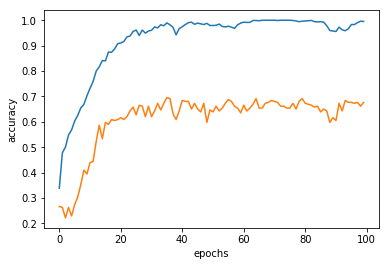

[[36  3  0  0  0  7]
 [ 1 27  2  7  6  1]
 [ 0  5 44  2  0  2]
 [ 2  6  1 27  4  6]
 [ 1  3  5  2 22  1]
 [ 5  6  1  2  5 24]]
              precision    recall  f1-score   support

        calm       0.80      0.78      0.79        46
       happy       0.54      0.61      0.57        44
       angry       0.83      0.83      0.83        53
     fearful       0.68      0.59      0.63        46
   surprised       0.59      0.65      0.62        34
         sad       0.59      0.56      0.57        43

    accuracy                           0.68       266
   macro avg       0.67      0.67      0.67       266
weighted avg       0.68      0.68      0.68       266



In [15]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(X_test, Y_test, emotion_list)

In this graph we can see that the model largely overfit around the 20st epoch
We can also see that the testing data's accuracy continues to grow.

In [18]:
# Now we save the model so we don't have to retrain it each time
vm.model.save("emotion_lstm.model")

In [37]:
# Here we load the model to check if nothing went wrong
vm.model.load("emotion_lstm.model")

In [19]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path += "/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad


In [20]:
vm.model._model.evaluate(X_savee, Y_savee)
print_metrics(X_savee, Y_savee, emotion_list)

580/580 [==============================] - 0s 809us/sample - loss: 8.4240 - acc: 0.2207
[[15 15  2  5 69 44]
 [ 3 19  1  6 37 16]
 [ 4 11  1  6 44 15]
 [ 4  6  3  5 42 20]
 [ 2  9  0  7 54  9]
 [17 11  0  5 39 34]]
              precision    recall  f1-score   support

        calm       0.33      0.10      0.15       150
       happy       0.27      0.23      0.25        82
       angry       0.14      0.01      0.02        81
     fearful       0.15      0.06      0.09        80
   surprised       0.19      0.67      0.30        81
         sad       0.25      0.32      0.28       106

    accuracy                           0.22       580
   macro avg       0.22      0.23      0.18       580
weighted avg       0.24      0.22      0.18       580



In [21]:
# Now we freeze every layer used for extracting features from data
for layer in vm.model._model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
vm.model._model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gaussian_noise
batch_normalization
lstm
activation
flatten
batch_normalization_1
gaussian_noise_1


In [22]:
# And we train the two last layers
# This is classic fine tuning
vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 464 samples, validate on 116 samples
Epoch 1/100
464/464 [==============================] - 2s 4ms/sample - loss: 5.0117 - acc: 0.2091 - val_loss: 5.2628 - val_acc: 0.2328
Epoch 2/100
464/464 [==============================] - 1s 3ms/sample - loss: 2.4653 - acc: 0.2931 - val_loss: 3.4826 - val_acc: 0.2241
Epoch 3/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.8851 - acc: 0.2953 - val_loss: 2.8134 - val_acc: 0.2241
Epoch 4/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.6437 - acc: 0.3384 - val_loss: 2.5926 - val_acc: 0.2328
Epoch 5/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.6355 - acc: 0.3772 - val_loss: 2.3865 - val_acc: 0.2241
Epoch 6/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.5163 - acc: 0.4009 - val_loss: 2.4888 - val_acc: 0.2414
Epoch 7/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.5414 - acc: 0.3707 - val_loss: 2.2258 - val_acc: 0.2500
Epoch 8/1

Epoch 61/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.2592 - acc: 0.5172 - val_loss: 2.6979 - val_acc: 0.2500
Epoch 62/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.3141 - acc: 0.4612 - val_loss: 2.8554 - val_acc: 0.2586
Epoch 63/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.3407 - acc: 0.4483 - val_loss: 2.7043 - val_acc: 0.2931
Epoch 64/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.3141 - acc: 0.5022 - val_loss: 2.8204 - val_acc: 0.2931
Epoch 65/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.2747 - acc: 0.4741 - val_loss: 2.8279 - val_acc: 0.2759
Epoch 66/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.3528 - acc: 0.4483 - val_loss: 2.7714 - val_acc: 0.2672
Epoch 67/100
464/464 [==============================] - 1s 3ms/sample - loss: 1.2508 - acc: 0.5000 - val_loss: 2.7938 - val_acc: 0.2500
Epoch 68/100
464/464 [==========================

In [23]:
print_metrics(X_savee, Y_savee, emotion_list)

[[111   0   2  10  10  17]
 [ 29   7  16  11  13   6]
 [ 25   0  28   2  20   6]
 [ 33   1   1  18  23   4]
 [ 18   2   9  15  27  10]
 [ 66   2   4   6  12  16]]
              precision    recall  f1-score   support

        calm       0.39      0.74      0.51       150
       happy       0.58      0.09      0.15        82
       angry       0.47      0.35      0.40        81
     fearful       0.29      0.23      0.25        80
   surprised       0.26      0.33      0.29        81
         sad       0.27      0.15      0.19       106

    accuracy                           0.36       580
   macro avg       0.38      0.31      0.30       580
weighted avg       0.37      0.36      0.32       580

